In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [64]:
df = pd.read_csv(r"train.csv")
df.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


## Check null values

In [65]:
print(df.isnull().sum())
print("\n",df.info())

date     0
store    0
item     0
sales    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB

 None


## Removing unnecessary columns

In [66]:
df = df.drop(['store','item'], axis=1)

In [67]:
# To transform date column in type = date
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


## Converting date to month period, and then sum the number of item in each month

In [68]:
df['date'] = df['date'].dt.to_period("M")
monthly_sales = df.groupby('date').sum().reset_index()

# To transform in timestamp to plot
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(4)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274


# Visualization

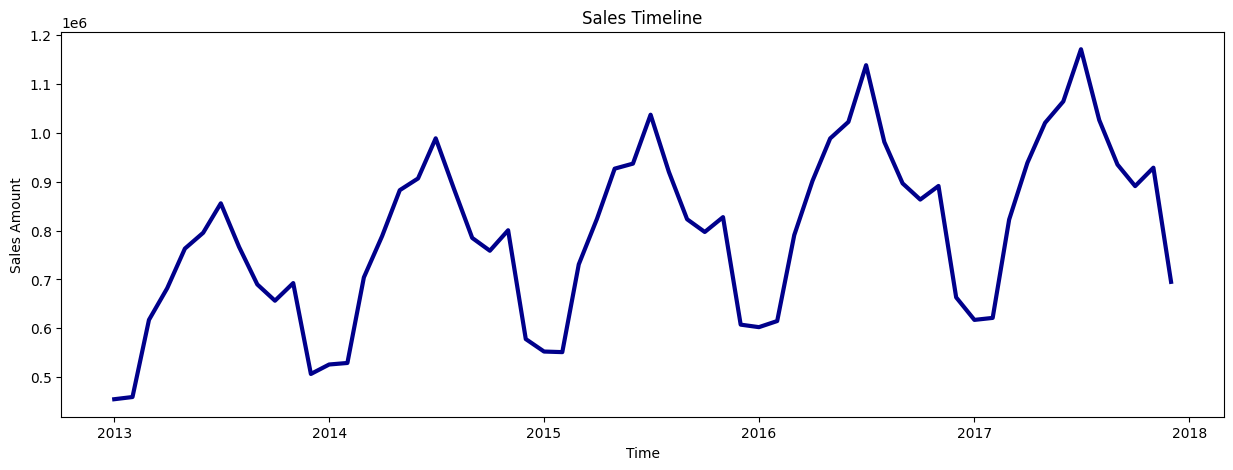

In [69]:
plt.figure(figsize=(15, 5))
plt.plot( monthly_sales['date'],
         monthly_sales['sales'],
         color= 'Darkblue',
         linewidth=3)

plt.title("Sales Timeline")
plt.xlabel("Time")
plt.ylabel("Sales Amount")

plt.show()

## call the difference on the sales columns to make the sales data stationery

In [70]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(8)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0


## Dropping off sales and date

In [71]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1) # will stay only the sales_diff

## Preparing the supervised data
Basic i'll to transform the data in a table (month1, month2...)

In [72]:
for i in range (1,13): # month 1 until month 12
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


index = Monhts
</hr>
columns = difference between months 
<hr/>

### Exemplo:
</hr>
Index 0 = january
</br>
month_1= January sales − December sale
</br>
month_2= February sales − December sale

## Split the Test and Train data

In [73]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

print('Train data = ',train_data.shape)
print('Test data = ',test_data.shape)

Train data =  (35, 13)
Test data =  (12, 13)


In [74]:
scaler = MinMaxScaler(feature_range=(-1,1)) # To transform data in -1 or 1
scaler.fit(train_data) # learn min/max only from train

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

""" Do NOT use .fit() on test data — that would "leak" future info into your model and make evaluation fake. """

' Do NOT use .fit() on test data — that would "leak" future info into your model and make evaluation fake. '

In [75]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1] 

y_test = y_test.ravel()
y_train = y_train.ravel()

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


## Predict DataFrame

In [76]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
predict_df.head()

,date
0,2017-01-01
1,2017-02-01
2,2017-03-01
3,2017-04-01
4,2017-05-01


In [77]:
act_sales = monthly_sales['sales'][-13:].to_list()
display(act_sales)

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

## Create the Linear Regression

In [78]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [79]:
lr_pre  = lr_pre.reshape(-1,1)

# (Above) This is a set matrix - Contains the input features of the test data, and the predicted outcome
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [80]:
result_list = []

for idx in range (0, len (lr_pre_test_set)):
    result_list.append(lr_pre_test_set[idx][0] + act_sales[idx])
lr_pre_series = pd.Series(result_list, name= "Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True) 

predict_df.head(3)

,date,Linear Prediction
0,2017-01-01,647914.785066
1,2017-02-01,628337.378158
2,2017-03-01,819519.000142


## Validation

In [81]:
# MSE
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], y_pred= monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], y_pred= monthly_sales['sales'][-12:])
lr_r2 = r2_score = (predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  16221.272385416896
Linear Regression MAE:  12433.184266490784
Linear Regression R2:  (0     6.479148e+05
1     6.283374e+05
2     8.195190e+05
3     9.436391e+05
4     1.033653e+06
5     1.065286e+06
6     1.201561e+06
7     1.002123e+06
8     9.415142e+05
9     9.080646e+05
10    9.167461e+05
11    6.947978e+05
Name: Linear Prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


## Prediction agains the actual sales

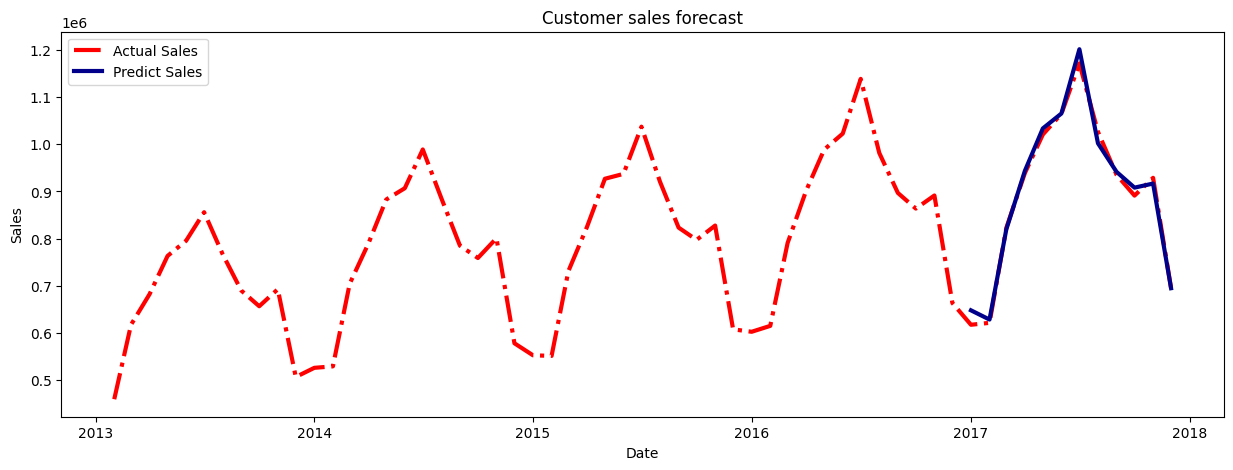

In [117]:
plt.figure(figsize=(15,5))

# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'], c= 'r', linewidth=3, linestyle='dashdot')

# Predict Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'], c= 'darkblue', linewidth=3)

plt.title("Customer sales forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predict Sales'])
plt.show()